# Project: Document Skew Detection
### Table of content:
  * Introduction
  * Modeling
  * Transfer Learning

### Introduction
We all would have stumped on a problem where the documents that we have will be misaligned, skewed and also could be wrapped. A lot of images scanners will ask us to rotate the images 
by ourselves or ask us to choose the four points for modification of perspective. 
But what is meant exactly by skew, it's any deviation of the image from that of the original document which is not parallel to the horizontal or vertical.

**Here we are trying to solve this probelm using *Deep Learning* approaches**

### Mount Colab to Google Drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

# Data is stored in my drive link
# https://drive.google.com/drive/folders/1Ad8F3KjaTFarE3Blwf3CEFWBrQZ4V07N?usp=sharing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [13]:
import tensorflow as tf
import os
import cv2
import json
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import random
from sklearn import preprocessing
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import math
from keras.utils.vis_utils import plot_model

### Reading Data

In [14]:
tr_path = '/content/drive/MyDrive/SkewDetection_CV/rdocuments/'
tr_csv = '/content/drive/MyDrive/SkewDetection_CV/r-images.csv'

### Image Preprocessing

In [15]:
def angle_sign(x):
  if x < 0:
    return 0
  else:
    return 1

# Applying standard scaler on data to normalize it
scaler = preprocessing.StandardScaler()

train_label_df = pd.read_csv(tr_csv)
train_label_df['angle'] = train_label_df['angle'].apply(lambda x: -1*(x))

# Transform the angles from degrees to radians
train_label_df['angle'] = train_label_df['angle'].apply(lambda x: (x*math.pi)/180)

# Scaling the data using standard scaler
train_label_df['angle_scaled'] = scaler.fit_transform(train_label_df['angle'].values.reshape(len(train_label_df), 1)) 
(img_width, img_height) = (224, 224)

train_label_df.head(5)

,id,angle,angle_scaled
0,Image-0--22Image_1.jpg,0.383972,1.025337
1,Image-0-38Image_10.png,-0.663225,-1.762974
2,Image-0-30Image_11.jpg,-0.523599,-1.391199
3,Image-0-25Image_12.JPG,-0.436332,-1.158840
4,Image-0-29Image_13.png,-0.506145,-1.344727


In [16]:
print("The train data has {} rows, and {} columns".format(train_label_df.shape[0], train_label_df.shape[1]))

The train data has 1450 rows, and 3 columns


In [17]:
scaler.inverse_transform(train_label_df['angle_scaled'][0].reshape(1,1))

array([[0.38397244]])

### EDA

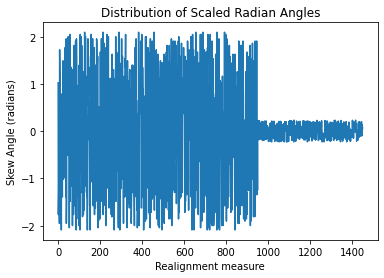

In [18]:
plt.title("Distribution of Scaled Radian Angles")
plt.xlabel("Realignment measure")
plt.ylabel("Skew Angle (radians)")
train_label_df['angle_scaled'].plot();

### Creating training and validation data

In [19]:
BATCH_SIZE = 32
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.20,
                                                          rescale=1/255,
                                                          zoom_range = 0.2,
                                                          brightness_range = (0.8, 1.2))
train_generator = datagen.flow_from_dataframe(dataframe=train_label_df, 
                                              directory=tr_path, 
                                              x_col="id", y_col="angle", 
                                              class_mode="raw",
                                              subset='training',
                                              target_size=(img_width, img_height), 
                                              batch_size=BATCH_SIZE)
valid_generator = datagen.flow_from_dataframe(dataframe=train_label_df, 
                                              directory=tr_path, 
                                              x_col="id", y_col="angle", 
                                              class_mode="raw",
                                              subset='validation',
                                              target_size=(img_width, img_height), 
                                              batch_size=BATCH_SIZE)

Found 1160 validated image filenames.
Found 290 validated image filenames.


In [20]:
x_train = []
for x in train_label_df['id']:
  # Reading images in (greyscale format)
  img = cv2.imread(os.path.join('/content/drive/MyDrive/SkewDetection_CV/rdocuments/', x), 0)
  resized_arr = cv2.resize(img, (img_width, img_height))
  x_train.append(resized_arr)

# Saving to and loading data from Google drive to execute faster
np.save('/content/drive/MyDrive/SkewDetection_CV/trainingData.npy', x_train)
#x_train = np.load('/content/drive/MyDrive/SkewDetection_CV/trainingData.npy')

In [21]:
x_np = np.array(x_train)
x_np = x_np.reshape(len(x_train), img_height, img_width, 1)
x_np = x_np/255

In [22]:
y_train = train_label_df['angle_scaled'].values
y_train[0:5]

array([ 1.0253372 , -1.76297391, -1.3911991 , -1.15883984, -1.34472724])

## Modeling

#### Model building

In [23]:
c_model = tf.keras.models.Sequential()
c_model.add(tf.keras.layers.Input(shape=(224, 224, 1)))
c_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                   activation='relu', padding='same'))
c_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
c_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                   activation='relu', padding='same'))
c_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
c_model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), 
                                   activation='relu', padding='same'))
c_model.add(tf.keras.layers.GlobalMaxPooling2D())
c_model.add(tf.keras.layers.Dense(512, activation='relu'))
c_model.add(tf.keras.layers.Dropout(0.2))
c_model.add(tf.keras.layers.Dense(256, activation='relu'))
c_model.add(tf.keras.layers.Dropout(0.2))
c_model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.linear))

c_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss=tf.keras.losses.mean_absolute_error,)

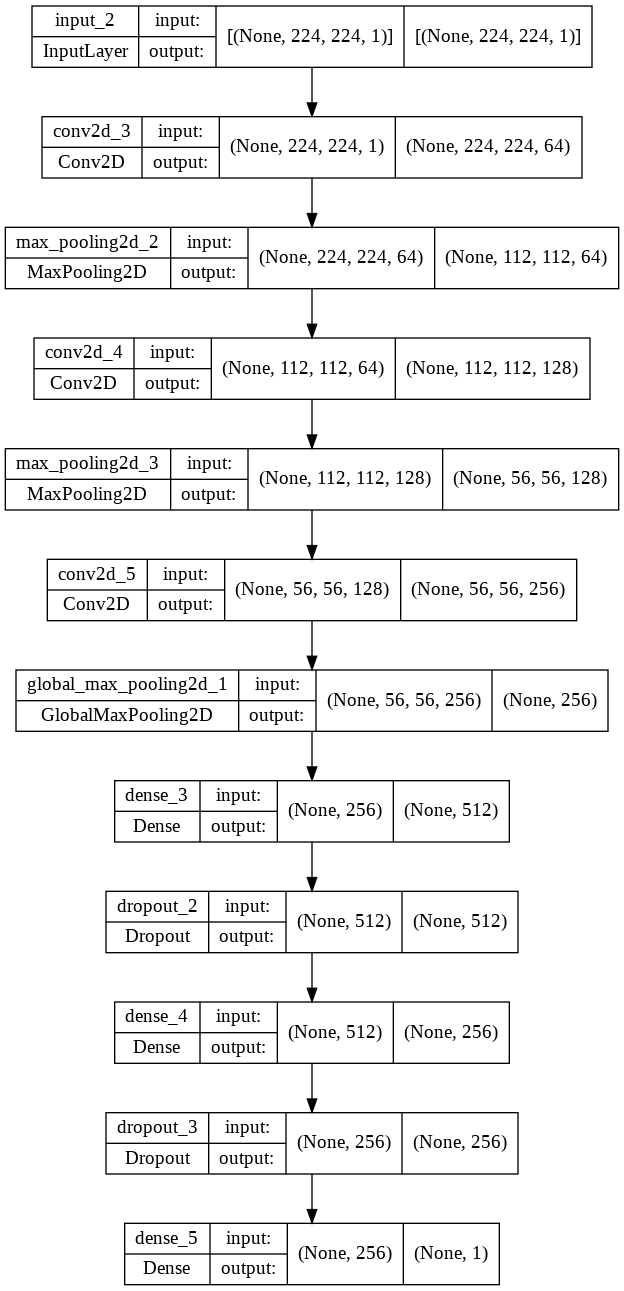

In [24]:
# Visualizing the model architecutre
plot_model(c_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Model Training

In [25]:
c_hist = c_model.fit(x_np,
                     y_train,
                     validation_split=0.2,
                     batch_size=32,
                     epochs=50,
                     verbose=2)
#initially batch size here was 64, I made it 32

Epoch 1/50
37/37 - 20s - loss: 0.8979 - val_loss: 0.1175 - 20s/epoch - 541ms/step
Epoch 2/50
37/37 - 8s - loss: 0.7829 - val_loss: 0.4043 - 8s/epoch - 215ms/step
Epoch 3/50
37/37 - 8s - loss: 0.4065 - val_loss: 0.2139 - 8s/epoch - 214ms/step
Epoch 4/50
37/37 - 8s - loss: 0.3110 - val_loss: 0.1168 - 8s/epoch - 214ms/step
Epoch 5/50
37/37 - 8s - loss: 0.2508 - val_loss: 0.1169 - 8s/epoch - 214ms/step
Epoch 6/50
37/37 - 8s - loss: 0.2081 - val_loss: 0.1720 - 8s/epoch - 215ms/step
Epoch 7/50
37/37 - 8s - loss: 0.1806 - val_loss: 0.0813 - 8s/epoch - 214ms/step
Epoch 8/50
37/37 - 8s - loss: 0.1590 - val_loss: 0.0619 - 8s/epoch - 215ms/step
Epoch 9/50
37/37 - 8s - loss: 0.1571 - val_loss: 0.1163 - 8s/epoch - 215ms/step
Epoch 10/50
37/37 - 8s - loss: 0.1624 - val_loss: 0.0663 - 8s/epoch - 215ms/step
Epoch 11/50
37/37 - 8s - loss: 0.1497 - val_loss: 0.0959 - 8s/epoch - 214ms/step
Epoch 12/50
37/37 - 8s - loss: 0.1296 - val_loss: 0.0584 - 8s/epoch - 215ms/step
Epoch 13/50
37/37 - 8s - loss: 0.11

In [26]:
# Saving model weights
#c_model.save('/content/drive/MyDrive/SkewDetection_CV/scaled_model_b_50eps.h5')

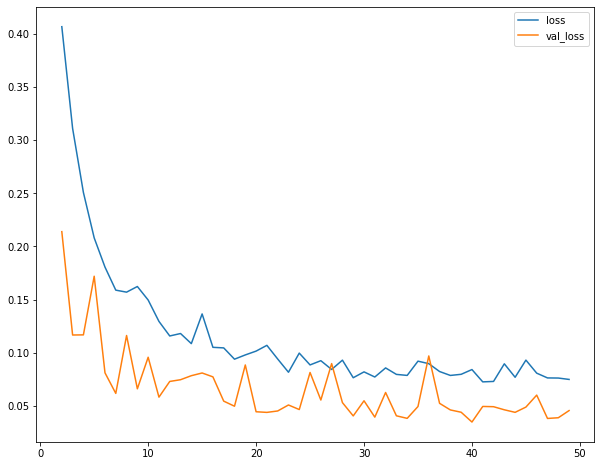

In [27]:
# displaying model history
his_df = pd.DataFrame(c_hist.history)
pt = his_df[2:].plot(figsize=(10, 8))
fig = pt.get_figure()

#### Model testing

In [28]:
images0 = os.listdir(tr_path)
idx = random.randint(600, 950)
image = cv2.imread('/content/drive/MyDrive/SkewDetection_CV/rdocuments/' + images0[idx], 0)
image = cv2.resize(image, (img_width, img_height))
image = image.reshape(1, img_height, img_width, 1)
image = image/255
angle = c_model.predict(image)
print(images0[idx])
print('-------------------------')
print(scaler.inverse_transform(train_label_df[train_label_df['id'] == images0[idx]][['angle_scaled']].values))

print(scaler.inverse_transform(angle))

Image-8--6Image_29.jpg
-------------------------
[[0.10471976]]
[[0.10537823]]


In [29]:
imge = cv2.imread('/content/drive/MyDrive/SkewDetection_CV/uOn7S.jpg', 0)
imge = cv2.resize(imge, (img_width, img_height))
imge = imge.reshape(1, img_height, img_width, 1)
imge = imge/255
angle = c_model.predict(imge)
rt_angle = scaler.inverse_transform(angle)[0][0]
print(rt_angle)

0.37716734


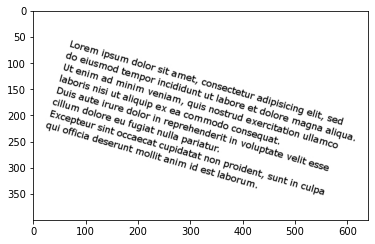

In [30]:
# The original test image
im1 = Image.open('/content/drive/MyDrive/SkewDetection_CV/uOn7S.jpg')
plt.imshow(im1);

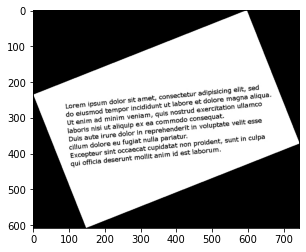

In [31]:
# The image after fixing its angle
im2 = im1.rotate((rt_angle*180)/math.pi, PIL.Image.NEAREST, expand = 1)
plt.imshow(im2);

## Transfer Learning

In [32]:
tr_path = '/content/drive/MyDrive/SkewDetection_CV/rdocuments/'
tr_csv = '/content/drive/MyDrive/SkewDetection_CV/r-images.csv'

train_label_df = pd.read_csv(tr_csv)

range_angle = max(train_label_df['angle']) - min(train_label_df['angle'])
train_label_df['angle'] = (train_label_df['angle'])/range_angle

(img_width, img_height) = (224, 224)
BATCH_SIZE = 16   #32

train_label_df.shape

(1450, 2)

In [33]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.10,
                                                          rescale=1/255,
                                                          zoom_range = 0.2,
                                                          brightness_range = (0.8, 1.2))
train_generator = datagen.flow_from_dataframe(dataframe=train_label_df, 
                                              directory=tr_path, 
                                              x_col="id", y_col="angle", 
                                              class_mode="raw",
                                              subset='training',
                                              target_size=(img_width, img_height), 
                                              batch_size=BATCH_SIZE)

valid_generator = datagen.flow_from_dataframe(dataframe=train_label_df, 
                                              directory=tr_path, 
                                              x_col="id", y_col="angle", 
                                              class_mode="raw",
                                              subset='validation',
                                              target_size=(img_width, img_height), 
                                              batch_size=BATCH_SIZE)

Found 1305 validated image filenames.
Found 145 validated image filenames.


In [34]:
t_model = tf.keras.models.Sequential()
t_model.add(hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
                   trainable=True))
t_model.add(tf.keras.layers.Dense(512, activation='relu'))
t_model.add(tf.keras.layers.Dropout(0.2))
t_model.add(tf.keras.layers.Dense(256, activation='relu'))
t_model.add(tf.keras.layers.Dense(128, activation='linear'))
t_model.add(tf.keras.layers.Dense(64, activation='linear'))
t_model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.linear))

t_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss=tf.keras.losses.MSE,
                metrics=[tf.keras.metrics.MAE])

In [35]:
t_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SkewDetection_CV/modelfinal.h5', 
                                       save_best_only=True,
                                      monitor='val_mean_absolute_error'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/SkewDetection_CV/logs')
]

In [36]:
training_steps_per_epoch = np.ceil(train_generator.samples / BATCH_SIZE)
validation_steps_per_epoch = np.ceil(valid_generator.samples / BATCH_SIZE) 

In [38]:
t_hist = t_model.fit(train_generator,
                     validation_data=valid_generator,
                     steps_per_epoch=training_steps_per_epoch,
                     epochs=60,
                     verbose=2, 
                     callbacks=t_callbacks)

Epoch 1/60
82/82 - 37s - loss: 0.1600 - mean_absolute_error: 0.0271 - val_loss: 0.1583 - val_mean_absolute_error: 0.0277 - 37s/epoch - 445ms/step
Epoch 2/60
82/82 - 33s - loss: 0.1566 - mean_absolute_error: 0.0244 - val_loss: 0.1564 - val_mean_absolute_error: 0.0374 - 33s/epoch - 407ms/step
Epoch 3/60
82/82 - 33s - loss: 0.1536 - mean_absolute_error: 0.0249 - val_loss: 0.1520 - val_mean_absolute_error: 0.0280 - 33s/epoch - 403ms/step
Epoch 4/60
82/82 - 33s - loss: 0.1503 - mean_absolute_error: 0.0237 - val_loss: 0.1510 - val_mean_absolute_error: 0.0484 - 33s/epoch - 406ms/step
Epoch 5/60
82/82 - 34s - loss: 0.1479 - mean_absolute_error: 0.0299 - val_loss: 0.1459 - val_mean_absolute_error: 0.0304 - 34s/epoch - 416ms/step
Epoch 6/60
82/82 - 35s - loss: 0.1439 - mean_absolute_error: 0.0225 - val_loss: 0.1431 - val_mean_absolute_error: 0.0330 - 35s/epoch - 423ms/step
Epoch 7/60
82/82 - 34s - loss: 0.1408 - mean_absolute_error: 0.0233 - val_loss: 0.1406 - val_mean_absolute_error: 0.0401 - 3

In [39]:
# Reading the test image in greyscale format
imge = cv2.imread('/content/drive/MyDrive/SkewDetection_CV/uOn7S.jpg', 0)
imge = cv2.resize(imge, (img_width, img_height))

# Stacking 3 grey channels of the image
imge = np.dstack((imge, imge, imge))

imge = imge.reshape(1, img_height, img_width, 3)
imge = imge/255
angle = t_model.predict(imge)
rt_angle = scaler.inverse_transform(angle)[0][0]
print(rt_angle)

-0.084568806


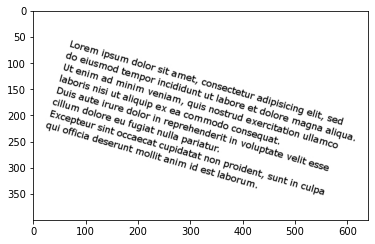

In [40]:
import matplotlib.pyplot as plt
im1 = Image.open('/content/drive/MyDrive/SkewDetection_CV/uOn7S.jpg')
plt.imshow(im1);

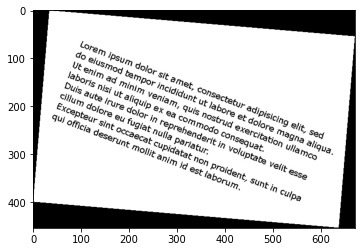

In [41]:
# Displaying the result after fixing its angle
im2 = im1.rotate((rt_angle*180)/math.pi, PIL.Image.NEAREST, expand = 1)
plt.imshow(im2);